In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
import sklearn

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:

pkg = mp.jupyter.open_source_package()
pkg

# COVID-19 Data
`jhu.edu-covid19-2.4.19` Last Update: 2020-04-23T04:27:29

_COVID 19 cases data from Johns Hopkins, augmented and reformtted_


This dataset processed and augments the COVID-19 data provided by Johns Hopkins
University Center for Systems Science and Engineering (JHU CSSE). [The source
data is checked into Github
daily.](https://github.com/CSSEGISandData/COVID-19/) and is collected from a
variety of sources.

This dataset reformats the data into tidy format, with dates expressed as
values instead of column headings, and adds several fields that are useful for
analysis.

The 'rate_t5d' column is the growth date from 5 days before the observation to
the observation. For example, for a row with a current observation of value
x_5, and a past observation of x_0, the rate_t5d is calculated as
e^((log(x_5)-log(x_0)) / 5)-1 . The result is that x_5 = x_0 * (1+rate_t5d)^5,
and rate_t5d from the previous 5 days

## Caveats

* China's minimum cases in the dataset is 548, so it's value for days sincle
  100 cases is shifted by 6 days. It's just a guess, but it looks good. 
* Countries that haven't reached 100 cases yet will have a days since 100 cases
  value that is always negative.
## Documentation Links

* [John Hopkins Project Homepage](https://systems.jhu.edu/research/public-health/ncov/) 

 
## Notes

* Version 2.x: The upstream source changed the data formats on 3/22
* Version 2.x: Country values that are aggregated from provinces now have a province value of 'aggregate'
## Contacts

* **Origin** [John Hopkins University Center for Systems Science and Engineering](https://systems.jhu.edu/)
* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [confirmed](notebooks/ProcessTimeseries.ipynb#confirmed_df)**. Confirmed Non-US cases by date and country
* ** [deaths](notebooks/ProcessTimeseries.ipynb#death_df)**. Non-US Death cases by date and country
* ** [recovered](notebooks/ProcessTimeseries.ipynb#recov_df)**. Non-US recoveries cases by date and country
* ** [confirmed_us](notebooks/ProcessTimeseries.ipynb#confirmed_us_df)**. Confirmed US cases by date and country
* ** [deaths_us](notebooks/ProcessTimeseries.ipynb#death_us_df)**. US Death  cases by date and country

## References
<ul><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/">ts_base_url</a></strong>. Base URL for time series data</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv">confirmed_ts_source</a></strong>. Source for time series of confirmed cases, excluding US</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv">death_ts_source</a></strong>. Source for time series of deaths, excluding US</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv">recov_ts_source</a></strong>. Source for time series of recoveries, excluding US</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv">confirmed_ts_us_source</a></strong>. Source for time series of confirmed cases, US Only</li><li> <strong><a href="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv">death_ts_us_source</a></strong>. Source for time series of deaths, US Only</li><ul>

In [3]:
conf_raw = pkg.reference('confirmed_ts_source').dataframe()

In [4]:
conf_raw[conf_raw['Country/Region'] == 'US']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20
225,NaN,US,37.0902,-95.7129,1,1,2,2,5,5,...,636350,667592,699706,732197,758809,784326,811865,840351,869170,905358


In [5]:
def process(df, val_field_name):
    t = df.drop(columns=['Lat','Long']).rename(columns={'Country/Region': 'country', 'Province/State': 'province'}).fillna('')
  
    # The countries frame sums regions of a country into whole countries. 
    countries = t[(t.province != '') | (t.province.isnull()) ].groupby('country').sum().reset_index()
    countries['province'] = 'aggregate'
    t = pd.concat([t, countries], sort=True)
    
    # Create a location field that uses both the country and province
    t['location'] = t.apply(lambda r: f"{r.country}{' - ' if r.province else ''}{r.province}", axis=1)
   
    # Turn the date columns int new rows
    t = t.set_index(['country','province','location'])
    t = t.stack().to_frame().reset_index().rename(columns={0:val_field_name,'level_3':'date'})
    t['date'] = pd.to_datetime(t['date'])
    
    t[val_field_name] = pd.to_numeric(t[val_field_name])
    
    # Find the date at which there are more than 10 cases. 
    
    min_date = t[t[val_field_name] >= 10].groupby('location').date.min().to_frame().rename(columns={'date': 'date_10'})
    t = t.merge(min_date, on='location', how='left')
    t['days_10'] = (t.date-t['date_10']).dt.days
    
    # Find the date at which there are more than 100 cases. 
    
    min_date = t[t[val_field_name] >= 100].groupby('location').date.min().to_frame().rename(columns={'date': 'date_100'})
    t = t.merge(min_date, on='location', how='left')
    t['days_100'] = (t.date-t['date_100']).dt.days

    # The min in this dataset for China is 548, not 100, so shift it by 6 days
    # to get it to align with other countries. It's a guess, but it looks good 
    t = t.copy()
    t.loc[t.country == 'China', ['days_100']] = t.loc[t.country == 'China', 'days_100'] + 6
    
    t.loc[t.country == 'China', ['days_10']] = t.loc[t.country == 'China', 'days_10'] + 6
    
    
    # Link in values for each location from 5 days ago, to calculate short-run rates. 
    
    t['date_m5'] = t.date-pd.Timedelta(days=5)
    t_past = t[['date', 'location', val_field_name]].copy().rename(columns={val_field_name:val_field_name+'_m5d', 'date':'date_m5'})
    t = t.merge(t_past, on=['date_m5', 'location'])

    tnz = t[ (t[val_field_name] != t[val_field_name+'_m5d']) & (t[val_field_name] !=0) & (t[val_field_name+'_m5d'] != 0) ]
    t['rate_t5d'] = np.exp((np.log(tnz[val_field_name])-np.log(tnz[val_field_name+'_m5d'])) / 5)-1

    # Check that the rate calculation is correct. 
    r1 = (t[val_field_name+'_m5d'] * np.power(1+t.rate_t5d,5) - t[val_field_name]).abs().sum()
    assert  r1 < 1./1.0e7, r1
    
    
    t.drop(columns=['date_m5', val_field_name+'_m5d' ], inplace = True)

    t[val_field_name+'_log'] = np.log(t[val_field_name]+1)

    return t
    
confirmed_df = process(conf_raw, 'confirmed')
confirmed_df.head().T
confirmed_df[confirmed_df.country=='US']

/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,country,province,location,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log
20025,US,,US,2020-01-27,5,2020-02-03,-7.0,2020-03-03,-36.0,0.379730,1.791759
20026,US,,US,2020-01-28,5,2020-02-03,-6.0,2020-03-03,-35.0,0.379730,1.791759
20027,US,,US,2020-01-29,5,2020-02-03,-5.0,2020-03-03,-34.0,0.201124,1.791759
20028,US,,US,2020-01-30,5,2020-02-03,-4.0,2020-03-03,-33.0,0.201124,1.791759
20029,US,,US,2020-01-31,7,2020-02-03,-3.0,2020-03-03,-32.0,0.069610,2.079442
...,...,...,...,...,...,...,...,...,...,...,...
20109,US,,US,2020-04-05,336802,2020-02-03,62.0,2020-03-03,33.0,0.123476,12.727253
20110,US,,US,2020-04-06,366317,2020-02-03,63.0,2020-03-03,34.0,0.114286,12.811257
20111,US,,US,2020-04-07,397121,2020-02-03,64.0,2020-03-03,35.0,0.102659,12.891999
20112,US,,US,2020-04-08,428654,2020-02-03,65.0,2020-03-03,36.0,0.092544,12.968408


In [6]:
death_raw = pkg.reference('death_ts_source').dataframe()
death_df = process(death_raw, 'death')


/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/eric/opt/anaconda3/envs/data/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
recov_raw = pkg.reference('recov_ts_source').dataframe()
recov_df = process(recov_raw, 'recovered')

In [8]:
confirmed_df.head().T

,0,1,2,3,4
country,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
province,,,,,
location,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
date,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00
confirmed,0,0,0,0,0
date_10,2020-03-14 00:00:00,2020-03-14 00:00:00,2020-03-14 00:00:00,2020-03-14 00:00:00,2020-03-14 00:00:00
days_10,-47,-46,-45,-44,-43
date_100,2020-03-27 00:00:00,2020-03-27 00:00:00,2020-03-27 00:00:00,2020-03-27 00:00:00,2020-03-27 00:00:00
days_100,-60,-59,-58,-57,-56
rate_t5d,NaN,NaN,NaN,NaN,NaN


,country,province,location,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log
10350,France,,France,2020-02-29,100,2020-02-08,21.0,2020-02-29,0.0,0.528142,4.615121
10358,France,,France,2020-03-01,130,2020-02-08,22.0,2020-02-29,1.0,0.561576,4.875197
10359,France,,France,2020-03-10,1784,2020-02-08,31.0,2020-02-29,10.0,0.364617,7.487174
10360,France,,France,2020-03-11,2281,2020-02-08,32.0,2020-02-29,11.0,0.284229,7.732808
10361,France,,France,2020-03-12,2281,2020-02-08,33.0,2020-02-29,12.0,0.191713,7.732808


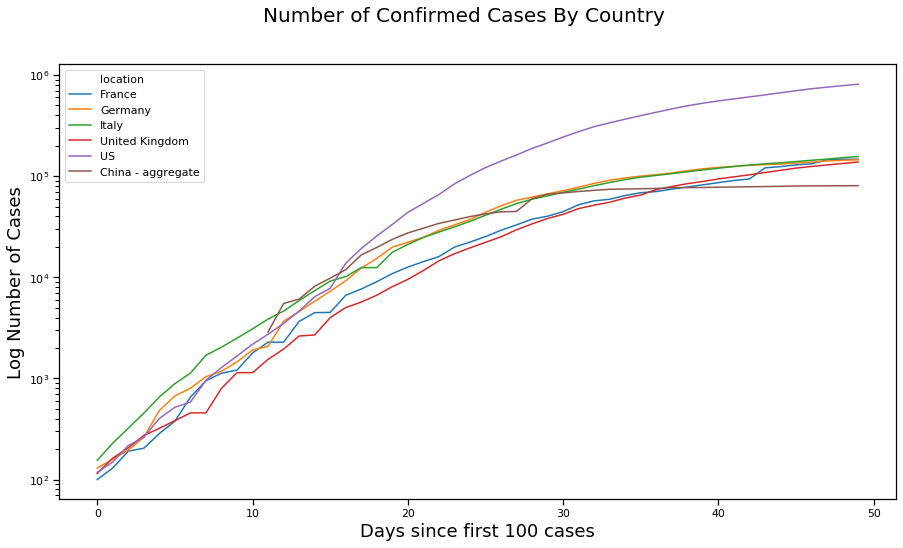

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
fig.suptitle('Number of Confirmed Cases By Country', fontsize=20)

t = confirmed_df[(confirmed_df.days_100<50) & (confirmed_df.days_100>=0)] 
t = t[t.location.isin( ['Italy','US','Germany','France', 'United Kingdom', 'China - aggregate'])]

display(t.head())
sns.lineplot(ax=ax, x='days_100',y='confirmed', data=t, hue='location', ci=None)
ax.set_xlabel('Days since first 100 cases', fontsize=18)
ax.set_ylabel('Log Number of Cases', fontsize=18)
ax.set_yscale('log')

In [10]:

death_raw.head().T.head(15)

,0,1,2,3,4
Province/State,NaN,NaN,NaN,NaN,NaN
Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola
Lat,33,41.1533,28.0339,42.5063,-11.2027
Long,65,20.1683,1.6596,1.5218,17.8739
1/22/20,0,0,0,0,0
1/23/20,0,0,0,0,0
1/24/20,0,0,0,0,0
1/25/20,0,0,0,0,0
1/26/20,0,0,0,0,0
1/27/20,0,0,0,0,0


In [12]:
def process_us(df, val_field_name):
    t = df.drop(columns=['Lat','Long_', 'iso2','iso3','Admin2','FIPS','code3','Country_Region','Province_State','Combined_Key'])
    t = t.dropna(subset=['UID'])
    t['UID'] = t.UID.astype('int').astype('str')
    #t = t.rename(columns={'Combined_Key': 'location', 'Country_Region': 'country', 'Province_State': 'province'}).fillna('')
    
    #if 'Population' in t.columns:
    t = t.drop(columns=['Population'])
    
    # Turn the date columns int new rows
    t = t.set_index(['UID',])
    t = t.stack().to_frame().reset_index()
    
    t = t.rename(columns={0:val_field_name,'level_1':'date'})
    
    t['date'] = pd.to_datetime(t['date'], format='%m/%d/%y')
    
    t[val_field_name] = pd.to_numeric(t[val_field_name])


    # Find the date at which there are more than 10 cases. 
    
    min_date = t[t[val_field_name] >= 10].groupby('UID').date.min().to_frame().rename(columns={'date': 'date_10'})
    t = t.merge(min_date, on='UID', how='left')
    t['days_10'] = (t.date-t['date_10']).dt.days
    
    # Find the date at which there are more than 100 cases. 
    
    min_date = t[t[val_field_name] >= 100].groupby('UID').date.min().to_frame().rename(columns={'date': 'date_100'})
    t = t.merge(min_date, on='UID', how='left')
    t['days_100'] = (t.date-t['date_100']).dt.days

    # Link in values for each location from 5 days ago, to calculate short-run rates. 
    
    t['date_m5'] = t.date-pd.Timedelta(days=5)
    t_past = t[['date', 'UID', val_field_name]].copy().rename(columns={val_field_name:val_field_name+'_m5d', 'date':'date_m5'})
    t = t.merge(t_past, on=['date_m5', 'UID'])

    tnz = t[ (t[val_field_name] != t[val_field_name+'_m5d']) & (t[val_field_name] !=0) & (t[val_field_name+'_m5d'] != 0) ]
    t['rate_t5d'] = np.exp((np.log(tnz[val_field_name])-np.log(tnz[val_field_name+'_m5d'])) / 5)-1

    # Check that the rate calculation is correct. 
    r1 = (t[val_field_name+'_m5d'] * np.power(1+t.rate_t5d,5) - t[val_field_name]).abs().sum()
    assert  r1 < 1./1.0e7, r1
    
    t.drop(columns=['date_m5', val_field_name+'_m5d' ], inplace = True)

    t[val_field_name+'_log'] = np.log(t[val_field_name]+1)

    return t

def process_loc(source, df):
    t = df[df.columns[:12]].drop_duplicates()
    t = t.rename(columns={'Combined_Key': 'location', 'Country_Region': 'country', 'Province_State': 'province'}).fillna('')
    t = t.dropna(subset=['UID'])
    t = t[~t.UID.isnull()]
    
    def p_uid(v):
        try:
            return str(int(v))
        except ValueError:
            return str(v)
    
    t['UID'] = t.UID.apply(p_uid)
    
    return source.merge(t, on='UID')


death_raw = pkg.reference('death_ts_us_source').dataframe()
death_us_df = process_loc(process_us(death_raw, 'death'), death_raw)

confirmed_raw = pkg.reference('death_ts_us_source').dataframe()
confirmed_us_df = process_loc(process_us(confirmed_raw, 'confirmed'), death_raw)



In [13]:

confirmed_us_df.head()

,UID,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log,iso2,iso3,code3,FIPS,Admin2,province,country,Lat,Long_,location,Population
0,16,2020-01-27,0,NaT,NaN,NaT,NaN,NaN,0.0,AS,ASM,16,60,,American Samoa,US,-14.271,-170.132,"American Samoa, US",55641
1,16,2020-01-28,0,NaT,NaN,NaT,NaN,NaN,0.0,AS,ASM,16,60,,American Samoa,US,-14.271,-170.132,"American Samoa, US",55641
2,16,2020-01-29,0,NaT,NaN,NaT,NaN,NaN,0.0,AS,ASM,16,60,,American Samoa,US,-14.271,-170.132,"American Samoa, US",55641
3,16,2020-01-30,0,NaT,NaN,NaT,NaN,NaN,0.0,AS,ASM,16,60,,American Samoa,US,-14.271,-170.132,"American Samoa, US",55641
4,16,2020-01-31,0,NaT,NaN,NaT,NaN,NaN,0.0,AS,ASM,16,60,,American Samoa,US,-14.271,-170.132,"American Samoa, US",55641


In [14]:
confirmed_us_df[confirmed_us_df.FIPS == 90055.0]

,UID,date,confirmed,date_10,days_10,date_100,days_100,rate_t5d,confirmed_log,iso2,iso3,code3,FIPS,Admin2,province,country,Lat,Long_,location,Population
289250,84090055,2020-01-27,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289251,84090055,2020-01-28,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289252,84090055,2020-01-29,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289253,84090055,2020-01-30,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289254,84090055,2020-01-31,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289334,84090055,2020-04-20,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289335,84090055,2020-04-21,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289336,84090055,2020-04-22,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
289337,84090055,2020-04-23,0,NaT,NaN,NaT,NaN,NaN,0.0,US,USA,840,90055,Unassigned,Wisconsin,US,0,0,"Unassigned, Wisconsin, US",0
